RNA-Seq measures the expression levels of genes. The data is analysed to measure differential gene expression between two groups of genes.
Useful packages: DESeq2

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("DESeq2"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’




In [2]:
install.packages(c("pheatmap"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(DESeq2)
library(tidyverse)
library(pheatmap)
library(RColorBrewer)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading r

In [4]:
# Reading in the raw count data
smoc2_rawcounts <- read.csv("/content/fibrosis_smoc2_rawcounts_unordered.csv")
head(smoc2_rawcounts)

,X,smoc2_fibrosis1,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_fibrosis3,smoc2_normal4,smoc2_fibrosis2
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693,0,0,0,0,0,0,0
2,ENSMUSG00000064842,0,0,0,0,0,0,0
3,ENSMUSG00000051951,72,30,0,3,36,1,51
4,ENSMUSG00000102851,0,0,0,0,0,0,0
5,ENSMUSG00000103377,0,0,1,0,0,0,0
6,ENSMUSG00000104017,0,0,0,0,0,0,0


In [5]:
# Creating the metadata dataframe
genotype <- c("smoc2_oe", "smoc2_oe", "smoc2_oe", "smoc2_oe", "smoc2_oe", "smoc2_oe", "smoc2_oe")
condition <- c("fibrosis", "fibrosis", "fibrosis", "fibrosis", "normal", "normal", "normal")

smoc2_metadata <- data.frame(genotype, condition)
rownames(smoc2_metadata) <- c("smoc2_fibrosis1", "smoc2_fibrosis2", "smoc2_fibrosis3", "smoc2_fibrosis4", "smoc2_normal1", "smoc2_normal3", "smoc2_normal4")
smoc2_metadata

,genotype,condition
,<chr>,<chr>
smoc2_fibrosis1,smoc2_oe,fibrosis
smoc2_fibrosis2,smoc2_oe,fibrosis
smoc2_fibrosis3,smoc2_oe,fibrosis
smoc2_fibrosis4,smoc2_oe,fibrosis
smoc2_normal1,smoc2_oe,normal
smoc2_normal3,smoc2_oe,normal
smoc2_normal4,smoc2_oe,normal


In [6]:
# Organising the data for DESeq2
# Use the match() function to reorder the columns of the raw counts so that it is in the same order as the rows of the metadata
reorder_idx <- match(rownames(smoc2_metadata), colnames(smoc2_rawcounts))

# Reorder the columns of the count data
reordered_smoc2_rawcounts <- smoc2_rawcounts[, reorder_idx]

# Create a DESeq2 object in a format that can be used for analysis
dds_smoc2 <- DESeqDataSetFromMatrix(countData =  reordered_smoc2_rawcounts,
                              colData = smoc2_metadata,
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [7]:
#Quality control on samples
#To generate normalised counts to accurately compare gene expression between samples

# Determine the size factors to use for normalization
dds_smoc2 <- estimateSizeFactors(dds_smoc2)

# Extract the normalized counts
smoc2_normalized_counts <- counts(dds_smoc2, normalized = TRUE)

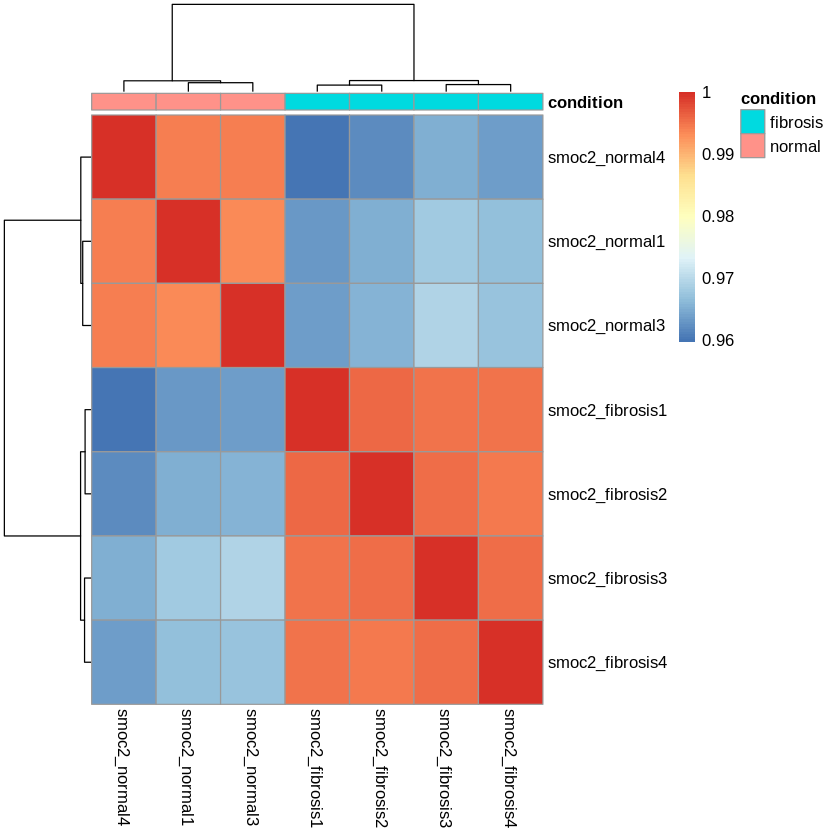

In [8]:
#Plotting a hierarchical heatmap allow us to visualise the variance between the samples

# Log-transform the normalized counts
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Extract the matrix of transformed counts
vsd_mat_smoc2 <- assay(vsd_smoc2)

# Compute the correlation values between samples
vsd_cor_smoc2 <- cor(vsd_mat_smoc2)

# Plot the heatmap
pheatmap(vsd_cor_smoc2, annotation = select(smoc2_metadata, condition))

using ntop=500 top features by variance



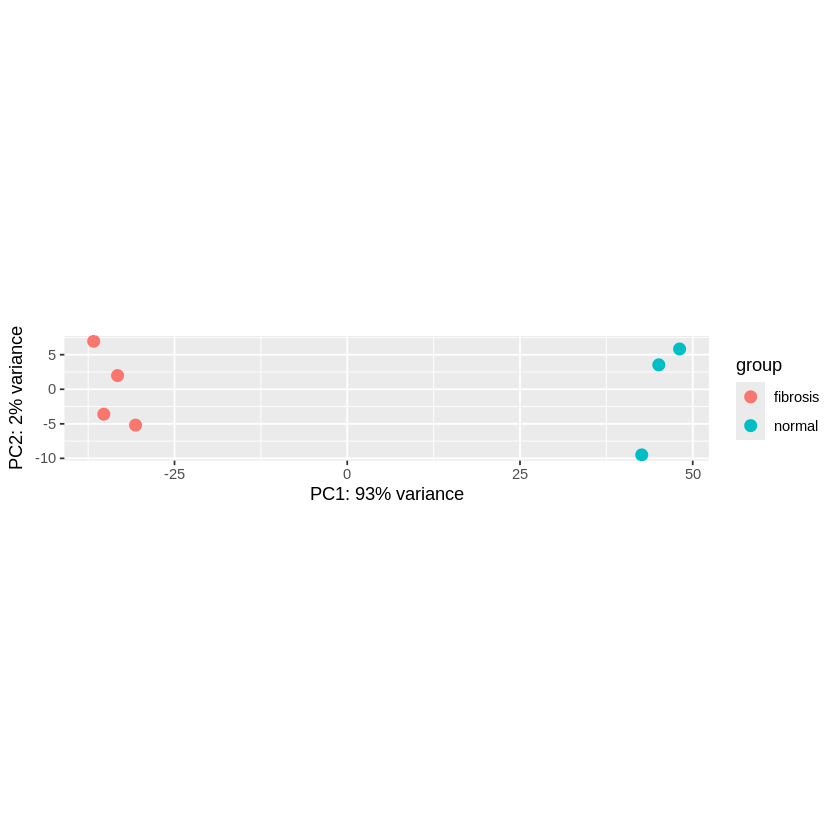

In [9]:
#PCA - Principal Component Analysis
#Plots your samples and plots lines between them known as Principal Components. These basically tell you how much of the variation in your data can be explained by the fact that there are different samples
#PCA is a method of dimension reduction. It reduces a multi-dimensional dataset to two dimensions.

# Transform the normalized counts
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)
# Plot the PCA of PC1 and PC2
plotPCA(vsd_smoc2, intgroup="condition")

In [10]:
#We now convert the samples matrix into a DESeq2 object as before, so it can be analysed
#We then finally run the analysis on it

# Create DESeq2 object
dds_smoc2 <- DESeqDataSetFromMatrix(countData = reordered_smoc2_rawcounts,
                 colData = smoc2_metadata,
                 design = ~ condition) #The design argument specifies the variables you want to control for

# Run the DESeq2 analysis
 dds_smoc2_ <- DESeq(dds_smoc2)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



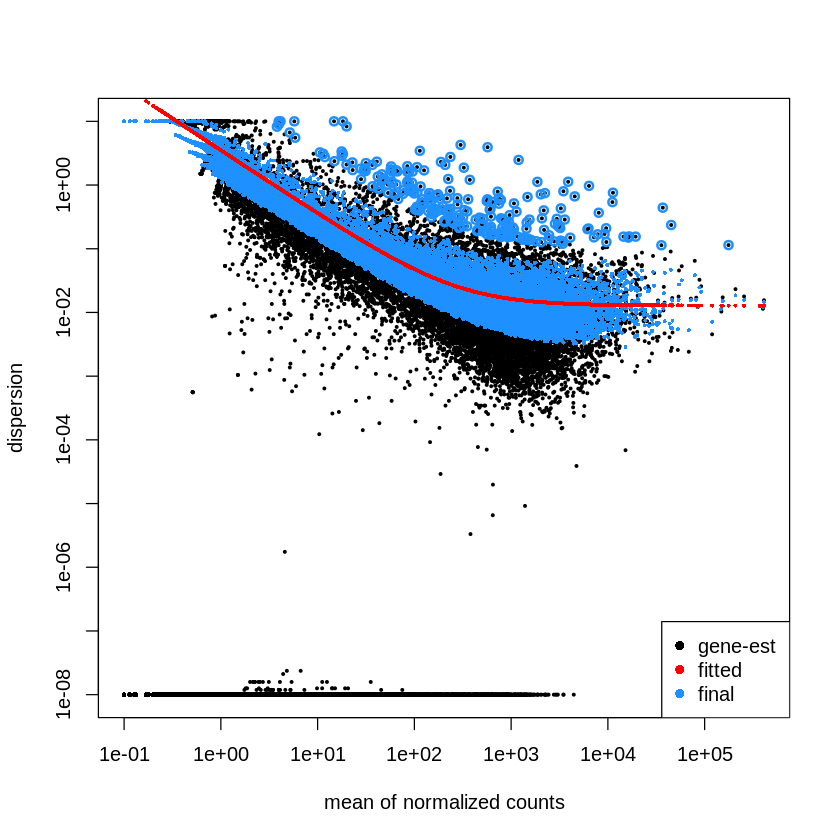

In [11]:
#In addition to running an analysis as above, we can plot the data using a negative binomial model
#And we can assess the fit of the data to the model

# Plot dispersions
plotDispEsts(dds_smoc2_)

In [12]:
#We have explored dispersions and fit our data to the DESeq2 model
#Now we need to extract the results

# Extract the results of the differential expression analysis
smoc2_res <- results(dds_smoc2_,
                contrast = c("condition", "fibrosis", "normal"),  #To extract the results for fibrosis relative to normal
                alpha = 0.05)

In [13]:
#We can improve the fold change estimates for the data by shrinking the log2 fold changes
#Log2 fold change = log2(fibrosis samples/normal samples)

# Shrink the log2 fold change estimates to be more accurate
smoc2_res <- lfcShrink(dds_smoc2_ ,
                    type = "normal",
                    contrast =  c("condition", "fibrosis", "normal"),
                    res = smoc2_res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [20]:
#We filter out genes not likely to be biologically relevant due to their being outliers
#We also want to reduce the chances of throwing out genes that are biologically relevant in the process
#We due this by changing the log2 fold change threshold

# Explore the results() function
#?results

# Extract results
smoc2_res <- results(dds_smoc2_,
                contrast = c("condition", "fibrosis", "normal"),
                alpha = 0.05,
                lfcThreshold = 0.32) #log changes threhold of 1.25 fold = log2 0.32

# Shrink the log2 fold changes
smoc2_res <- lfcShrink(dds_smoc2_,
                    type = "normal",
                    contrast = c("condition", "fibrosis", "normal"),
                    res = smoc2_res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [15]:
#We can now explore our extracted results and locate the differentially expressed genes according to oue alpha

# Get an overview of the results
summary(smoc2_res)


out of 29556 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4011, 14%
LFC < 0 (down)     : 3552, 12%
outliers [1]       : 15, 0.051%
low counts [2]     : 7207, 24%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [16]:
#We now extract significant results

# Save results as a data frame
smoc2_res_all <- data.frame(smoc2_res)

# Subset the results to only return the significant genes with p-adjusted values less than 0.05
smoc2_res_sig <- subset(smoc2_res_all, padj < 0.05)

Warning message:
“Removed 25395 rows containing missing values or values outside the scale range
(`geom_point()`).”


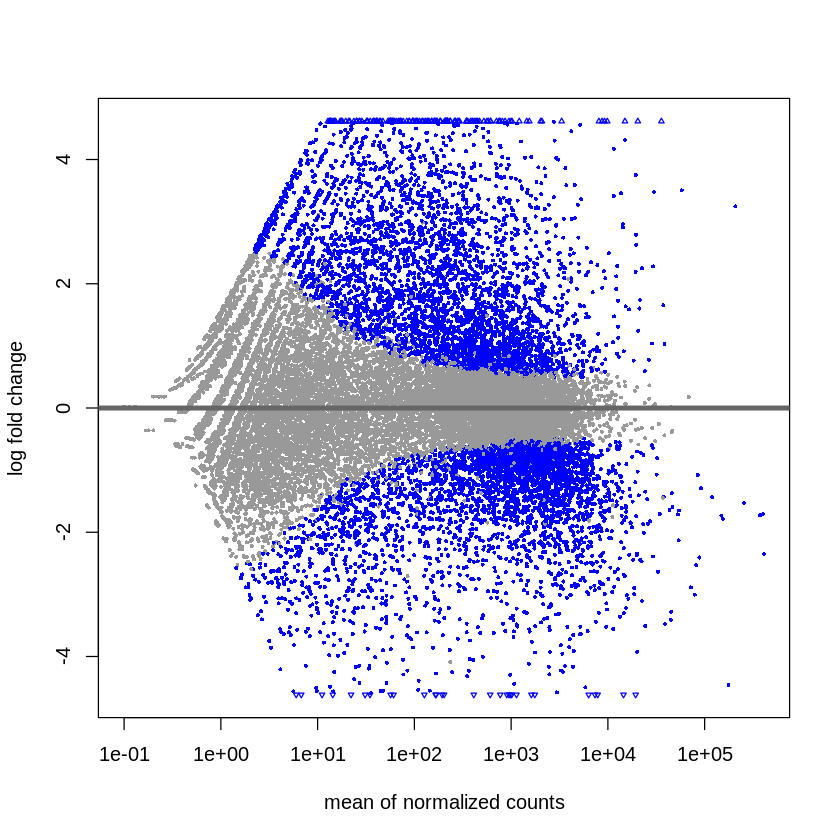

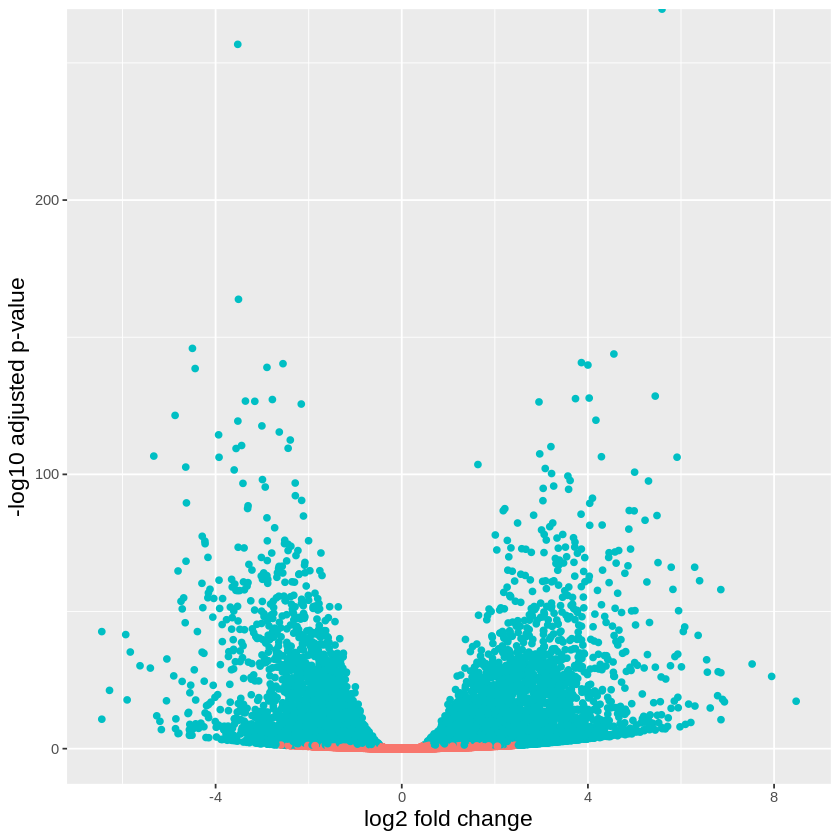

In [17]:
#The results can be adequately explored through visualisations

# Create MA plot
plotMA(smoc2_res)

# Generate logical column
smoc2_res_all <- data.frame(smoc2_res) %>% mutate(threshold = padj < 0.05)

# Create the volcano plot
ggplot(smoc2_res_all) +
        geom_point(aes(x = log2FoldChange, y = -log10(padj), color = threshold)) +
        xlab("log2 fold change") +
        ylab("-log10 adjusted p-value") +
        theme(legend.position = "none",
              plot.title = element_text(size = rel(1.5), hjust = 0.5),
              axis.title = element_text(size = rel(1.25)))

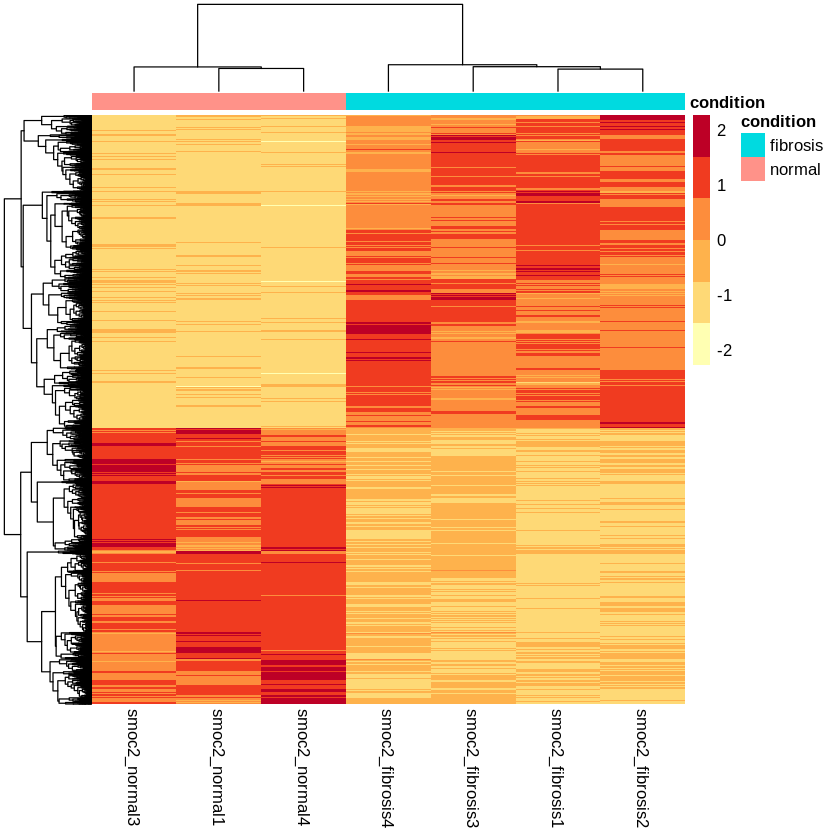

In [21]:
#Continued
#Convert normalized counts to a dataframe
smoc2_normalized_counts <- data.frame(smoc2_normalized_counts)

# Subset normalized counts to significant genes
sig_norm_counts_smoc2 <- smoc2_normalized_counts[rownames(smoc2_res_sig), ]

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

# Plot heatmap
pheatmap(sig_norm_counts_smoc2,
         color = heat_colors,
         cluster_rows = T,
         show_rownames = F,
         annotation = select(smoc2_metadata, condition),
         scale = "row")

**RNA-Seq Differential Expression Analysis Workflow Summary**

 **Check that all of the samples are in the same order in the metadata and count data**

all(rownames(all_metadata) %in% colnames(all_rawcounts))

 **DESeq object to test for the effect of fibrosis regardless of genotype**

dds_all <- DESeqDataSetFromMatrix(countData = all_rawcounts,
                       colData = all_metadata,
                        design = ~ condition + genotype)


 **DESeq object to test for the effect of genotype on the effect of fibrosis**

dds_complex <- DESeqDataSetFromMatrix(countData = all_rawcounts,
                                colData = all_metadata,
                                design = ~ genotype + condition + genotype:condition)

 **Log transform counts for QC**

vsd_all <- vst(dds_all, blind = TRUE)


 **Create heatmap of sample correlation values**

 vsd_all %>%
        assay() %>%
        cor() %>%
        pheatmap(annotation = select(all_metadata, c("genotype", "condition")))


 **Create the PCA plot for PC1 and PC2 and color by condition**

plotPCA(vsd_all, intgroup = "condition")

 **Create the PCA plot for PC1 and PC2 and color by genotype**

plotPCA(vsd_all, intgroup = "genotype")

**Select significant genes with padj < 0.05**

smoc2_sig <- subset(res_all, padj < 0.05) %>%
  				data.frame() %>%
  				rownames_to_column(var = "geneID")


**Extract the top 6 genes with padj values**

smoc2_sig %>%
	arrange(padj) %>%
	select(geneID, padj) %>%
	head()